In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Los datos están en 
https://timeseriesclassification.com/description.php?Dataset=DodgerLoopDay

In [2]:
!pip3 install aeon --break-system-packages
import os
import aeon
from aeon.datasets import load_from_tsfile

Defaulting to user installation because normal site-packages is not writeable


In [12]:
train_x, train_y = load_from_tsfile("DodgerLoopDay/DodgerLoopDay_TRAIN.ts")
train_y

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3',
       '3', '3', '3', '3', '3', '3', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '5', '5', '5', '5', '5', '5', '5', '5', '5',
       '5', '5', '5', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6',
       '6', '6', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7'],
      dtype='<U1')

In [4]:
np.shape(train_x)

(78, 1, 288)

In [5]:
train_x[0][0]

array([12., 18., 11., 11., 19., 17.,  4.,  6.,  8., 12., 11.,  6., 10.,
       10.,  9.,  5.,  5.,  8., 10.,  1.,  6.,  9., 11.,  5., 12.,  7.,
       10., 10.,  5., 10., 11., 10., 12.,  4.,  6.,  8.,  6.,  9.,  4.,
        4.,  8.,  7.,  4.,  1.,  2.,  7.,  4.,  7.,  3.,  5.,  1.,  4.,
        9.,  4.,  2.,  3.,  3.,  1.,  1.,  1.,  3.,  5.,  3.,  6.,  2.,
        4.,  7.,  4.,  4.,  3.,  1.,  4.,  3.,  1.,  6.,  3.,  4.,  5.,
        6.,  9.,  8.,  3.,  2.,  6., 10.,  8.,  7.,  8.,  9.,  0., 13.,
        6.,  6., 14., 10., 14., 10., 10.,  9., 11., 12.,  8., 14., 11.,
       11., 18., 20., 18., 24., 17., 10., 11., 12., 20., 21., 21., 20.,
       18., 31., 17., 19., 24., 20., 19., 19., 19., 18., 15., 19., 19.,
       18., 24., 18., 13., 23., 23., 23., 20.,  9., 32., 45., 29., 24.,
       21., 18., 20., 28., 24., 15., 25., 16., 38., 25., 25., 21., 20.,
       28., 23., 19., 19., 23., 14., 32., 27., 29., 30., 33., 20., 37.,
       26., 42., 35., 33., 23., 24., 36., 28., 26., 28., 27., 30

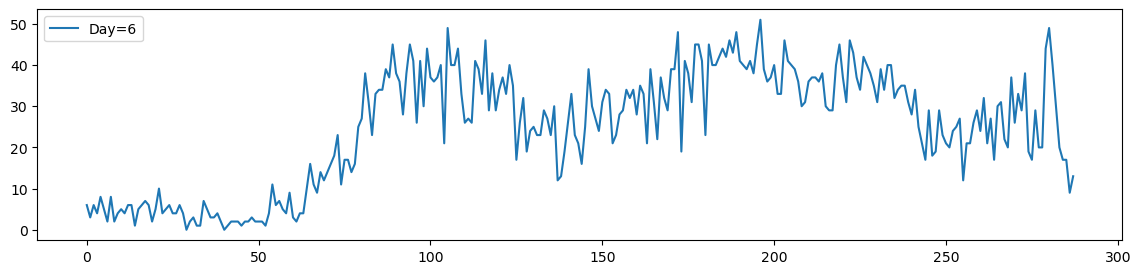

In [6]:
plt.figure(figsize=(14,3))
plt.plot(train_x[57][0],label="Day={}".format(train_y[57]))
plt.legend()
plt.show()

In [7]:
train_y[57]

'6'

# Práctica... ¿Qué vamos a hacer?

## Parte 1:
- Buscamos siete series de tiempo, una para cada día
- Para cada día (para cada serie de tiempo) hagamos el proceso completo de análisis de la serie temporal, que significa:
    - Hacer un gráfico para cada serie
    - Establecer la descomposición de la serie (Tendencia, estacionalidad, ruido..)
    - Hacer la prueba de Dickey-Fuller para establecer si es verdad es estacional o no.
    - Calcular la auto-correlación y analizar la gráfica de autocorrelación.
- Luego finalmente para cada serie (para cada día) hacer una predicción usando Exponential smooth forecast (parte III del otro notebook)
- Hacer una tabla resumen con las métricas de la predicción
- Hacer conclusiones, analizar todo!

## Parte 2:
- Ahora  vamos a hacer un dataframe que tenga todas las series en un solo dataset con su correspondiente label.
- Entonces ahora queremos hacer un modelo de clustering y clasificación (kmeans, PCA, UMAP, random forest, etc....) para determinar si es posible clasificar las series de tiempo en términos de los labels que son justamente los dias, es decir, a ver si podemos predecir el día en términos de algún modelo.

Eso es todo!

# Para la predicción...

## Ajuste algunos parámetros y juege un poco con la estimación!
Algunas otras opciones: https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html

In [8]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

data=pd.DataFrame(train_x[0][0])
data[data==0]=0.1
train, test = data[:220], data[220:]
hwes_model = ExponentialSmoothing(train, trend="add",seasonal="multiplicative",
                                  seasonal_periods=15).fit(smoothing_level=0.25, 
                                                           smoothing_slope=0.12, 
                                                           smoothing_seasonal=0.8)
#hwes_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.25, smoothing_slope=0.12)
#Algunas otras opciones: https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html
hwes_forecast = hwes_model.forecast(steps=len(test))

/tmp/ipykernel_265559/4210210966.py:7: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  seasonal_periods=15).fit(smoothing_level=0.25,
/home/dsp/.local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


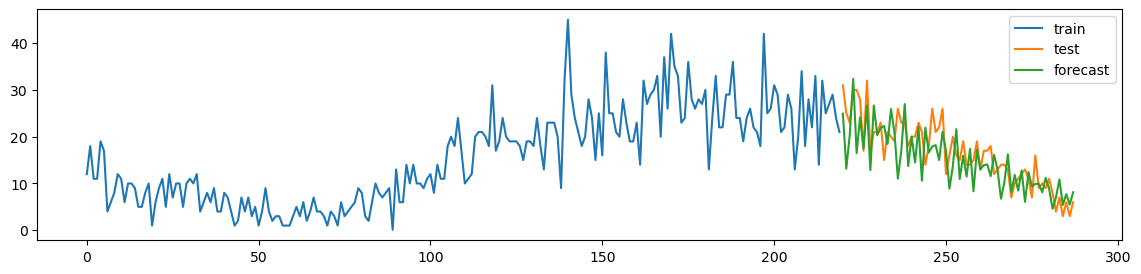

In [9]:
plt.figure(figsize=(14,3))
train[0].plot(label="train")
test[0].plot(label="test")
hwes_forecast.plot(label="forecast")
plt.legend()
plt.show()

In [10]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
print("RMSE:",np.sqrt(mean_squared_error(test,hwes_forecast)))
print("r2-score:",r2_score(test,hwes_forecast))
print("Correlation coefficient:",np.corrcoef(test[0],hwes_forecast)[0][1])

RMSE: 5.108017818940137
r2-score: 0.4504377592625701
Correlation coefficient: 0.7318005663253582
